# GPT from scratch in PyTorch
## Importing Modules

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
import re
import torch.nn.functional as F
from torch.utils.data import DataLoader

## Data Loading and Preprocessing

In [2]:
# For csv file:-
texts = pd.read_csv('/kaggle/input/persaude-corpus-2/persuade_corpus_1.0.csv')['full_text'].tolist()

# For text file:-

# DATA_PATH = '/kaggle/input/english-bookcorpus/en.txt'
# lines = []
# with open(DATA_PATH,'r') as f:
#     for i in range(50000):
#         lines.append(f.readline())
# print(len(lines))

# Take out k number of training samples from the whole corpus

# random.seed(24)
# texts = random.choices(lines,k=50000)
# del lines

In [4]:
# Using RegEx to clean the data
def preprocess(text):
    text = text.replace('\n', ' ')
    text = re.sub('@.*?\s+', '', text)
    text = re.sub('#.*?\s+', '', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.lower()
    text = text.strip()
    return text

In [5]:
# Store the preprocessed data into a new file
train_set = [preprocess(t) for t in texts]
with open('input.txt', 'w') as f:
    f.write('\n'.join(train_set))

In [6]:
import sentencepiece as spm

# train the tokenizer on the train set
spm.SentencePieceTrainer.train(
    input='input.txt',
    model_prefix='wikidata',
    model_type='bpe',
    pad_id=0,
    bos_id=1,
    eos_id=2,
    unk_id=3
)

# load the tokenizer model
tokenizer = spm.SentencePieceProcessor(model_file='wikidata.model')

from IPython.display import clear_output
clear_output(wait=True)

In [7]:
toks = tokenizer.Encode('I am creating GPT from scratch, it is going to be amazing',out_type=str, add_bos=True, add_eos=True, enable_sampling=True, alpha=0, nbest_size=-1)
print(toks)

['<s>', '▁', 'I', '▁am', '▁creating', '▁', 'GPT', '▁from', '▁sc', 'rat', 'ch', ',', '▁it', '▁is', '▁going', '▁to', '▁be', '▁amazing', '</s>']


In [8]:
# Tokenize all text in train and test set
train_sequence = tokenizer.Encode(train_set, add_bos=True, add_eos=True,alpha=0)

In [86]:
# Setting hyperparameters
# Note: d_model should be divisible by n_heads
d_model = 768
n_heads = 12
seq_len = 256
batch_size = 64
vocab_size = tokenizer.vocab_size()

In [75]:
#  Convert lists to tensors
train_sequence_tensors = [torch.tensor(seq[:seq_len]) for seq in train_sequence]

# Pad train sequence
max_length_train = max([len(seq) for seq in train_sequence_tensors])
padded_train_sequence = torch.nn.utils.rnn.pad_sequence(train_sequence_tensors, batch_first=True, padding_value=0)  # Assuming padding value is 0

print(padded_train_sequence.shape)

torch.Size([285383, 256])


In [76]:
train_loader = DataLoader(padded_train_sequence,batch_size=batch_size,shuffle=True)

for d in train_loader:
    print(d.shape)
    print(d)
    break

torch.Size([64, 256])
tensor([[   1,  902,  693,  ...,   35, 3774, 5732],
        [   1,  969, 4099,  ...,   76,  487,  125],
        [   1,   14,  532,  ...,   35,  240,   88],
        ...,
        [   1,  512,   37,  ...,    0,    0,    0],
        [   1,  902, 1702,  ...,   14,  228,  125],
        [   1,    8,  318,  ...,    0,    0,    0]])


# Model Building

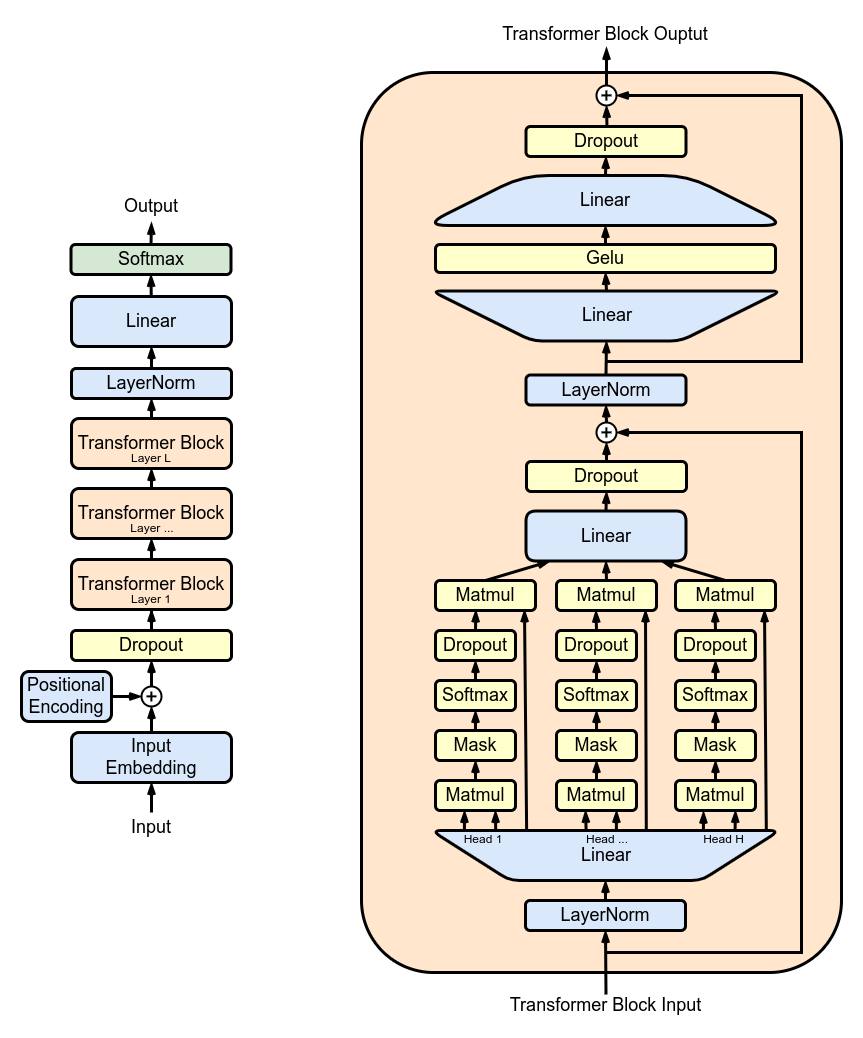

In [79]:
import math
def positional_encoding(length, depth):
    pe = torch.zeros(depth, length)
    position = torch.arange(0, depth, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, length, 2).float() * (-math.log(10000.0) / length))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
#     pe = pe.unsqueeze(0).transpose(0, 1)
    return pe

class PositionalEmbedding(nn.Module):
    def __init__(self,vocab_size,seq_len,d_model):
        super(PositionalEmbedding,self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size,d_model)
        self.pos_encoding = positional_encoding(d_model,seq_len).to('cuda')
        self.dropout = nn.Dropout(0.5)
    
    def forward(self,x):
        length = x.size(0)
        x = self.embedding(x)
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32).to('cuda'))
        pos_enc_out = self.pos_encoding.unsqueeze(0)
        x = x + pos_enc_out
        x = self.dropout(x)
        return x

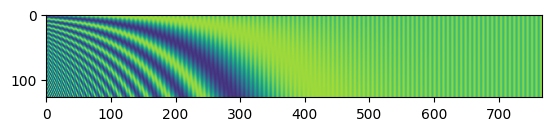

In [71]:
import matplotlib.pyplot as plt
plt.imshow(positional_encoding(d_model,seq_len));

In [ ]:
# Checking positional embedding
posEmb = PositionalEmbedding(vocab_size,seq_len,d_model).to('cuda')
input_tensor = torch.randint(0,vocab_size,(batch_size, seq_len)).to('cuda')
print(input_tensor.shape)
output_tensor = posEmb(input_tensor)
print(output_tensor.shape)

In [80]:
class Decoder(nn.Module):
    def __init__(self,d_model,n_heads):
        super(Decoder,self).__init__()
        self.attention = nn.MultiheadAttention(d_model,n_heads,batch_first=True,dropout=0.2)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model,d_model*4),
            nn.GELU(),
            nn.Linear(d_model*4,d_model),
            nn.Dropout(0.2)
        )
        self.dropout1 = nn.Dropout(0.2)
        
    def forward(self,x):
        x = self.layer_norm2(x)
        attention_output,_ = self.attention(x,x,x,attn_mask=nn.Transformer.generate_square_subsequent_mask(x.size(1)).to('cuda'),need_weights=False)
        x = x + self.dropout1(attention_output)
        x = self.layer_norm2(x)
        ffn_out = self.feed_forward(x)
        x = x + ffn_out
        return x

In [81]:
class GPT(nn.Module):
    def __init__(self,d_model,n_heads,vocab_size,seq_len):
        super(GPT,self).__init__()
        self.embedding1 = nn.Embedding(vocab_size,d_model)
        self.embedding2 = nn.Embedding(seq_len,d_model)
        self.layers = nn.ModuleList([Decoder(d_model,n_heads) for _ in range(12)])
        
        self.layer_norm = nn.LayerNorm(d_model)
        self.final_layer = nn.Linear(d_model,vocab_size)
            
    def forward(self,x):
        B,T = x.size()
        tok_emb = self.embedding1(x) # (B,T,C)
        pos_emb = self.embedding2(torch.arange(T, device='cuda')) # (T,C)
        x = tok_emb + pos_emb
        for layer in self.layers:
            x = layer(x)
        x = self.layer_norm(x)
        x = self.final_layer(x)
        return x

In [ ]:
# Testing the GPT Model
input_tensor = torch.randint(0,vocab_size,(batch_size, seq_len)).to('cuda')
print(input_tensor.shape)
gpt = GPT(d_model,n_heads,vocab_size,seq_len).to('cuda')
output = gpt(input_tensor)
print(output.shape)

In [63]:
def masked_loss(label, pred):
    ce_loss = F.cross_entropy(pred.permute(0,2,1), label, ignore_index=-1)
    mask = (label != 0).float()
    total_loss = torch.sum(ce_loss * mask.view(-1)) / torch.sum(mask)
    return total_loss

def masked_accuracy(label, pred):
    pred = pred.argmax(dim=2)
    match = label.eq(pred)
    mask = label.ne(0)
    match = match & mask
    match = match.float()
    mask = mask.float()
    return match.sum() / mask.sum()
    return match.sum()/(len(match)*100)

In [39]:
# Example of target with class indices
target = torch.randint(5, (3,8,), dtype=torch.int64)
input = torch.randn(3, 5, 8, requires_grad=True)
loss = F.cross_entropy(input, target)
print(input.shape)
print(target.shape)
print(loss)

torch.Size([3, 5, 8])
torch.Size([3, 8])
tensor(2.0866, grad_fn=<NllLoss2DBackward0>)


In [ ]:
print(masked_loss(input_tensor,output))
print(masked_accuracy(input_tensor,output))

In [87]:
gpt = GPT(d_model,n_heads,vocab_size,seq_len).to('cuda')
optimizer = torch.optim.Adam(gpt.parameters(),lr=1e-4)

In [88]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(gpt):,} trainable parameters")

The model has 97,548,608 trainable parameters


In [85]:
gpt

GPT(
  (embedding1): Embedding(8000, 768)
  (embedding2): Embedding(256, 768)
  (layers): ModuleList(
    (0-11): 12 x Decoder(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=3072, out_features=768, bias=True)
        (3): Dropout(p=0.2, inplace=False)
      )
      (dropout1): Dropout(p=0.2, inplace=False)
    )
  )
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (final_layer): Linear(in_features=768, out_features=8000, bias=True)
)

## Training and Inference

In [ ]:
from tqdm import tqdm
for epoch in range(2):
    total_loss = 0
    total_accuracy = 0
    
    for batch_idx, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        data = data.to('cuda')
        output = gpt(data)
        loss = masked_loss(data, output)
        accuracy = masked_accuracy(data, output)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_accuracy += accuracy.item()
        
        if batch_idx % 100 == 99:
            print('Epoch {} [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(
                epoch+1, batch_idx+1, len(train_loader), total_loss / 100, total_accuracy / 100))
            total_loss = 0.0
            total_accuracy = 0.0

print('Training finished!')

In [65]:
def generate(prompt='', max_len=seq_len, k=1):
    prompt = preprocess(prompt)
    input_ids = tokenizer.Encode([prompt],add_bos=True)
    input_ids[0] = input_ids[0] + [0]*(max_len - len(input_ids[0]))
    input_ids = torch.tensor(input_ids, dtype=torch.long).to('cuda')
    output_ids = []
    
    for i in range(max_len):
        with torch.no_grad():
            predictions = gpt(input_ids)
        predictions = F.softmax(predictions, dim=2)
        top_k_preds = torch.topk(predictions, k, dim=2)[1][0].detach().tolist()
        
        pred_idx = random.choice(top_k_preds[i])
        if pred_idx == tokenizer.eos_id():
            break
        output_ids.append(int(pred_idx))
        pred_idx = torch.tensor([[pred_idx]], dtype=torch.long)
        input_ids[0][i]=pred_idx
    
    output_seq = tokenizer.Decode(output_ids)
    return output_seq

In [ ]:
prompt = 'The ability to stay connected to people we know despite'
print(prompt + ' '+generate(prompt, k=20))